Redoing the period fits with everything I've learned from GD394 etc.

In [15]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [16]:
wddvs = Table.read('dv_lists/wd_dvs.ecsv')
mddvs = Table.read('dv_lists/bd_dvs.ecsv')

In [17]:
wdt, wdv, wde = np.array(wddvs['MJD'])*24, np.array(wddvs['VELOCITY']), np.array(wddvs['ERROR'])
mdt, mdv, mde = np.array(mddvs['MJD'])*24, np.array(mddvs['VELOCITY']), np.array(mddvs['ERROR'])


Fit the companion first

4.225117143350449


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


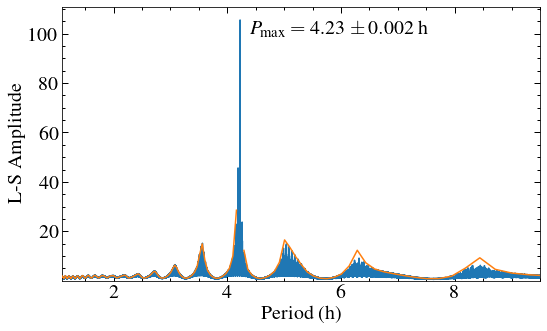

In [18]:
import math
dates  = np.array(wddvs['MJD'])
nights = np.array([math.floor(date) for date in dates])
#print(nights)
cols =  []
for i , n in enumerate(np.unique(nights)):
    for night in nights:
        if night == n:
            cols.append('C{}'.format(i))
cols = np.array(cols)
#print(cols)

#fitter = fitting.LevMarLSQFitter()


frequency, power = LombScargle(mdt, mdv,dy=mde, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)
period = 1/frequency[np.argmax(power)]
print(period)

#periodogram wo 2018 observations
frequency2, power2 = LombScargle(mdt[4:], mdv[4:],dy=mde[4:], normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)


plt.figure(figsize=(8, 5))

#plt.subplot(121)
plt.plot(1/frequency, np.sqrt(power))
plt.plot(1/frequency2, np.sqrt(power2), zorder=10)
plt.xlabel('Period (h)')
plt.ylabel('L-S Amplitude')
plt.xlim(1.1, 9.5)
plt.ylim(0.01)
plt.annotate(r'$P_{\mathrm{max}} = $'+'{0:10.2f} $\pm\,0.002$ h'.format(period), (4.4, 100), xycoords = 'data')
#plt.xscale('log')
#plt.yscale('log')
#plt.axhline(np.sqrt(fa99), ls='--', c='0.5')

#plt.subplot(122)
#for i in range(len(mdt)):
 #   plt.errorbar((mdt[i]/period %1), mdv[i], yerr=mde[i], marker='o', ls='none', color=cols[i])
#plt.xlabel('Phase')
#plt.ylabel('Velocity (km\,s$^{-1}$)')
plt.tight_layout()
#plt.savefig('plots/1144_periodogram.pdf')


Same for the wd lines, can't hurt to try

5.133290318421386


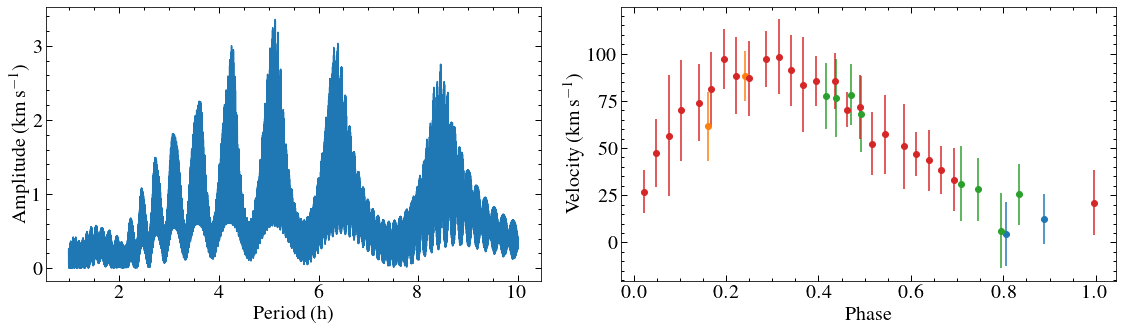

In [19]:
import math
dates  = np.array(wddvs['MJD'])
nights = np.array([math.floor(date) for date in dates])
#print(nights)
cols =  []
for i , n in enumerate(np.unique(nights)):
    for night in nights:
        if night == n:
            cols.append('C{}'.format(i))
cols = np.array(cols)
#print(cols)

fitter = fitting.LevMarLSQFitter()

frequency, power = LombScargle(wdt, wdv,dy=wde, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=10)
wdperiod = 1/frequency[np.argmax(power)]
print(wdperiod)

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(1/frequency, np.sqrt(power))
plt.xlabel('Period (h)')
plt.ylabel('Amplitude (km\,s$^{-1}$)')
#plt.axhline(np.sqrt(fa99), ls='--', c='0.5')

plt.subplot(122)
for i in range(len(wdt)):
    plt.errorbar((wdt[i]/wdperiod %1), wdv[i], yerr=wde[i], marker='o', ls='none', color=cols[i])
plt.xlabel('Phase')
plt.ylabel('Velocity (km\,s$^{-1}$)')
plt.tight_layout()

Nope. Fold on m dwarf period and fit.

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=197.3720162, frequency=1., phase=0.10112108)>

    [1]: <Const1D(amplitude=26.92188675)>
Parameters:
       amplitude_0     frequency_0       phase_0          amplitude_1    
    ------------------ ----------- ------------------- ------------------
    197.37201619998856         1.0 0.10112107672088018 26.921886749526635
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-35.58527844, frequency=1., phase=0.10006294)>

    [1]: <Const1D(amplitude=58.65675667)>
Parameters:
       amplitude_0     frequency_0       phase_0          amplitude_1   
    ------------------ ----------- ------------------- -----------------
    -35.58527843572102         1.0 0.10006294361894294 58.65675666535868
gr redshift 31.734869915832043 2.0573283791902637
M dwarf amplitude 197.37201619998856 0.771

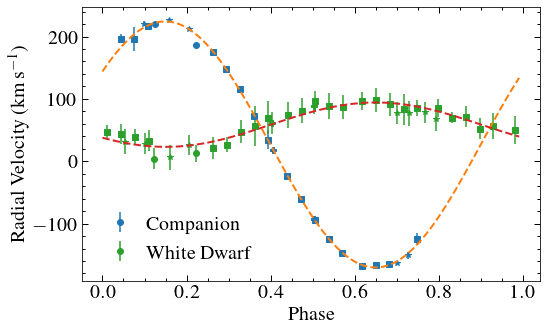

In [20]:
def make_syms(data):
    dates  = np.array(data['MJD'])
    nights = np.array([math.floor(date) for date in dates])
    syms =  []
    symlist = ['o', 'P', '*', 's']
    for i , n in enumerate(np.unique(nights)):
        for night in nights:
            if night == n:
                syms.append(symlist[i])
    return np.array(syms)


plt.figure(figsize=(8,5))

foldt = mdt/period % 1


syms = make_syms(mddvs)
for i in range(len(mdt)):
    if i == 0:
        plt.errorbar(foldt[i], mdv[i], yerr=mde[i], marker=syms[i], ls='none', c='C0', label='Companion')
    else:
        plt.errorbar(foldt[i], mdv[i], yerr=mde[i], marker=syms[i], ls='none', c='C0')

sin_mod =  models.Sine1D(amplitude=150, frequency=1, fixed=dict(frequency=True)) +  models.Const1D(50)
sin_fit = fitter(sin_mod, foldt, mdv, weights= 1/mde, maxiter=1000000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
timefit = np.arange(0,1, 0.01)
plt.plot(timefit, sin_fit(timefit), ls='--', lw=2, zorder=5, c='C1')
plt.xlim()
print(sin_fit)


wfoldt = wdt/period % 1


syms = make_syms(wddvs)
for i in range(len(wdt)):
    if i == 0:
        plt.errorbar(wfoldt[i], wdv[i], yerr=wde[i], marker=syms[i], ls='none', c='C2', label='White Dwarf')
    else:
        plt.errorbar(wfoldt[i], wdv[i], yerr=wde[i], marker=syms[i], ls='none', c='C2')
#plt.errorbar(wfoldt, wdv, yerr=wde, marker='o', ls='none')

wdsin_mod =  models.Sine1D(amplitude=10, frequency=1, fixed=dict(frequency=True)) +  models.Const1D(40)#, bounds = dict(amplitude=[30, 50]))
wdsin_fit = fitter(wdsin_mod, wfoldt, wdv, weights= 1/wde, maxiter=1000000)
wdfit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(timefit, wdsin_fit(timefit), ls='--', lw=2, zorder=5, C='C3')
plt.xlim()
print(wdsin_fit)

gr = wdsin_fit[1].amplitude - sin_fit[1].amplitude
gre = (wdfit_e[2]**2 + fit_e[2]**2)**0.5
print('gr redshift', gr, gre )

md_amp = sin_fit[0].amplitude.value 
md_amp_e = (fit_e[0]**2 + fit_e[1]**2)**0.5
print('M dwarf amplitude', md_amp, md_amp_e  )


wd_amp = abs(wdsin_fit[0].amplitude) 
wd_amp_e = (wdfit_e[0]**2 + wdfit_e[1]**2)**0.5
print('W dwarf amplitude', wd_amp, wd_amp_e  )

plt.legend()
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km\,s$^{-1}$)')
plt.tight_layout()
plt.savefig('plots/1144_velocities.pdf')

Nicola's catalouge predicts a GR redshift of 16.1. Guo+ predicts 20. Can we constrain the fit? No?

In [21]:
mwdn =  0.45
mwdg = 0.49
v_ratio = wd_amp/md_amp
percent_error = ((md_amp_e/md_amp)**2+(wd_amp_e/wd_amp)**2)**0.5
for wdm in [mwdn, mwdg]:
    md_mass = v_ratio *wdm
    md_mass_error = md_mass * percent_error
    print(md_mass, md_mass_error)

0.0811329569631026 0.005034872079828243
0.08834477535982282 0.005482416264701864


In [22]:
print(np.mean(mde))
print(np.median(mde))
print(np.std(mde))

4.201211047293812
2.5936100622704457
4.297076750404553


In [23]:
mde

array([ 2.49736425,  2.52836217,  2.90184447,  4.75292409,  2.43321605,
        6.20634928,  4.02030693,  1.48798853,  2.65885796,  2.401225  ,
        0.94979045,  1.5007293 ,  1.27555665, 15.0499853 ,  1.47754682,
        1.91714912,  0.09299648,  2.08523058,  2.12424359,  4.31110292,
        3.12748274,  3.25716412,  9.72195773,  7.40665453, 19.26192486,
        3.7835333 ])

In [24]:
print(np.mean(wde))
print(np.median(wde))
print(np.std(wde))

17.848165734593223
17.219262941643322
4.303553504140336


Can I go the other way and fit the model from the folded data onto the unfolded data?

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=205.72547271, frequency=0.23640709, phase=-0.01833069)>

    [1]: <Const1D(amplitude=13.8081061)>
Parameters:
       amplitude_0       frequency_0           phase_0           amplitude_1    
    ----------------- ------------------ -------------------- ------------------
    205.7254727062443 0.2364070948192148 -0.01833068543784905 13.808106104221539
4.22999149312638 0.0004808110456315094


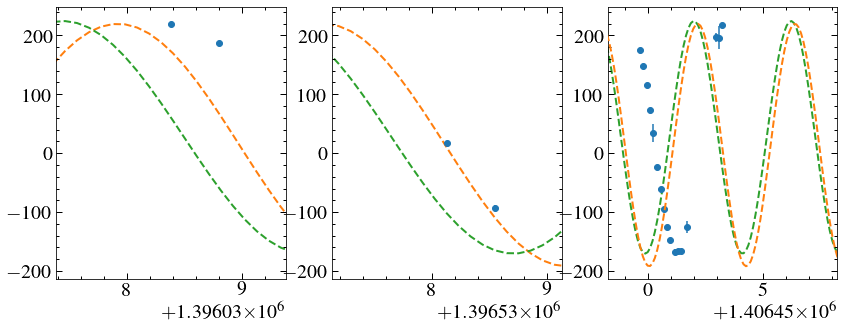

In [25]:
fitter = fitting.LevMarLSQFitter()
sin_mod2 =  models.Sine1D(amplitude=197.37, frequency=0.2364, phase=0.)+models.Const1D(26.92)
#sin_mod2 =  models.Sine1D(amplitude=200, frequency=1/4.23)+models.Const1D(30)

sin_mod2.frequency_0.bounds = [0.95*(1/4.23), 1.05*(1/4.23)]
#sin_mod2.amplitude_0.bounds = [0.95*abs(sin_fit[0].amplitude), 1.05*abs(sin_fit[0].amplitude)]
#sin_mod2.amplitude_1.bounds = [0.95*abs(sin_fit[1].amplitude), 1.05*abs(sin_fit[1].amplitude)] 

sin_fit2 = fitter(sin_mod2, mdt, mdv, weights= 1/mde, maxiter=1000000000)
fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))
timefit2 = np.linspace(mdt[0]-10,mdt[-1]+10, 100000)

plt.subplot(131)
plt.errorbar(mdt, mdv, yerr=mde, marker='o', ls='none')
plt.plot(timefit2, sin_fit2(timefit2), ls='--', lw=2, zorder=-5, c='C1')
plt.plot(timefit2, sin_mod2(timefit2), ls='--', lw=2, zorder=-5, c='C2')
plt.xlim(mdt[0]-1, mdt[0]+1)


plt.subplot(132)
plt.errorbar(mdt, mdv, yerr=mde, marker='o', ls='none')
plt.plot(timefit2, sin_fit2(timefit2), ls='--', lw=2, zorder=-5, c='C1')
plt.plot(timefit2, sin_mod2(timefit2), ls='--', lw=2, zorder=-5, c='C2')
plt.xlim(mdt[2]-1, mdt[2]+1)



plt.subplot(133)
plt.errorbar(mdt, mdv, yerr=mde, marker='o', ls='none')
plt.plot(timefit2, sin_fit2(timefit2), ls='--', lw=2, zorder=5, c='C1')
plt.plot(timefit2, sin_mod2(timefit2), ls='--', lw=2, zorder=-5, c='C2')

#plt.plot(mdt, sin_fit2(mdt))
plt.xlim(mdt[-1]-5, mdt[-1]+5)

print(sin_fit2)
print(1/sin_fit2[0].frequency, fit_e2[1]/(sin_fit2[0].frequency**2) )


In [26]:
sin_fit2[0].frequency

Parameter('frequency', value=0.2364070948192148, bounds=(0.2245862884160756, 0.24822695035460993))

In [27]:
1/period

0.23667982829158113

In [28]:
1/4.23

0.23640661938534277

20210929 try a new fit using limfit to just the later rv points

In [29]:
mdt, mdv, mde = np.array(mddvs['MJD'])[4:], np.array(mddvs['VELOCITY'])[4:], np.array(mddvs['ERROR'])[4:]


[[Model]]
    Model(sin)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 22
    # variables        = 4
    chi-square         = 30497.3147
    reduced chi-square = 1694.29526
    Akaike info crit   = 167.155732
    Bayesian info crit = 171.519902
[[Variables]]
    freq:   5.68723382 +/- 5.4626e-05 (0.00%) (init = 5.687204)
    amp:    190.894013 +/- 58.4990967 (30.64%) (init = 200)
    phase: -1.30458773 +/- 3.20291624 (245.51%) (init = 0.5)
    gamma:  27.0720393 +/- 1.93584796 (7.15%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(freq, phase)  = -1.000
    C(amp, phase)   = -0.999
    C(freq, amp)    =  0.999
    C(freq, gamma)  =  0.636
    C(phase, gamma) = -0.636
    C(amp, gamma)   =  0.625


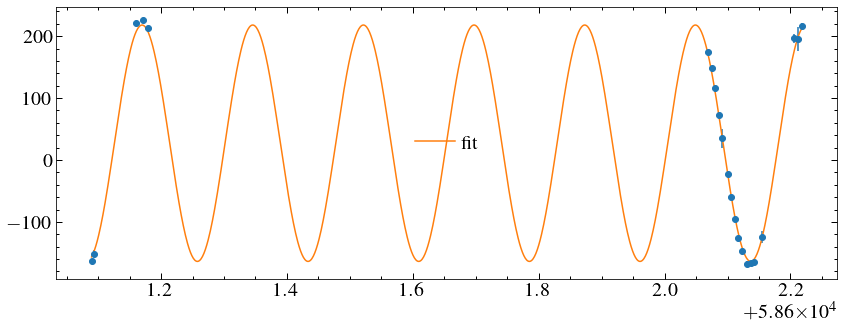

4.219977716643992


In [54]:
from lmfit import Model, Parameters

# def sinefunction(x, a, b, c):
#     return a + b * np.sin(x*np.pi/180.0 + c)


def sin(x, freq, amp, phase, gamma):
    """for fitting to time series"""
    return amp*np.sin(2.*np.pi*(freq*x+phase))+ gamma

smodel = Model(sin)
result = smodel.fit(mdv, x=mdt,weights = mde, freq=24/4.22, amp=200, phase=0.5, gamma=10)

print(result.fit_report())

# plt.plot(xdeg, y, 'o', label='data')#
plt.errorbar(mdt, mdv, yerr=mde, marker='o', ls='none')

timefit = np.linspace(min(mdt), max(mdt), 1000)

plt.plot(timefit, result.eval(x=timefit), label='fit')
# plt.plot(mdt, result.best_fit, label='fit')
plt.legend()
plt.show()

p1 = 1/(result.best_values['freq'])*u.day.to(u.hr)
print(p1)
# lcfold = lcnf.fold(p1, normalize_phase=True)

# def sin_fix(x, amp, phase):
#     """for fitting to time series"""
#     return amp*np.sin(2.*np.pi*(1*x+phase))

# foldmodel = Model(sin_fix)

# result2 = foldmodel.fit(lcfold.flux, x=lcfold.time.value, amp=result.best_values['amp'], phase=0)


# print(result2.fit_report())

# # plt.plot(xdeg, y, 'o', label='data')#
# plt.plot(lcfold.time.value, lcfold.flux)

# plt.plot(lcfold.time.value, result2.best_fit, '*', label='fit')
# plt.legend()
# plt.show()

[[Model]]
    Model(sin)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 33
    # variables        = 4
    chi-square         = 748263.007
    reduced chi-square = 25802.1727
    Akaike info crit   = 338.957074
    Bayesian info crit = 344.943104
[[Variables]]
    freq:   5.68720651 +/- 3.1756e-05 (0.00%) (init = 5.687204)
    amp:    32.9183835 +/- 6.45715810 (19.62%) (init = 30)
    phase: -0.19690182 +/- 1.87805839 (953.80%) (init = 0.1)
    gamma:  59.7249310 +/- 1.71084407 (2.86%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(freq, phase)  = -1.000
    C(freq, amp)    =  0.940
    C(amp, phase)   = -0.939
    C(amp, gamma)   = -0.328
    C(phase, gamma) =  0.319
    C(freq, gamma)  = -0.318


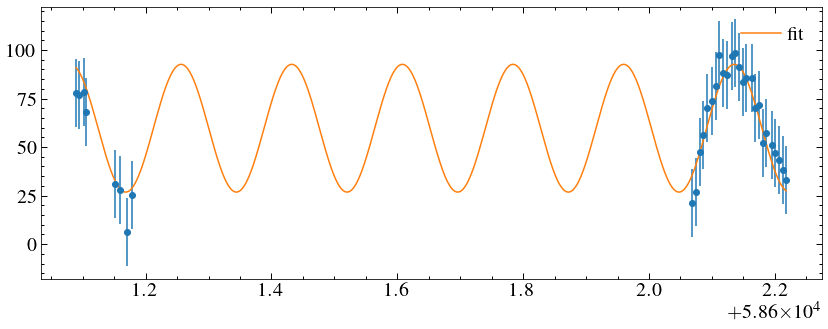

4.219997981991933


In [57]:
wdt, wdv, wde = np.array(wddvs['MJD'])[4:], np.array(wddvs['VELOCITY'])[4:], np.array(wddvs['ERROR'])[4]



result2 = smodel.fit(wdv, x=wdt,weights = wde, freq=24/4.22, amp=30, phase=0.1, gamma=10)

print(result2.fit_report())

# plt.plot(xdeg, y, 'o', label='data')#
plt.errorbar(wdt, wdv, yerr=wde, marker='o', ls='none')

plt.plot(timefit, result2.eval(x=timefit), label='fit')
# plt.plot(mdt, result.best_fit, label='fit')
plt.legend()
plt.show()

p1 = 1/(result2.best_values['freq'])*u.day.to(u.hr)
print(p1)